# Análise de interpretabilidade para o modelo NGBoost

Este notebook analisará a interpretabilidade do melhor modelo treinado com o algoritmo *NGBoost*.

**Autor**: Edélio Gabriel Magalhães de Jesus.

<a id='interp'></a>
## 1. Interpretabilidade via SHAP

<a id='oqeshap'></a>
### 1.1 O que é o *SHAP*?

![image](https://shap.readthedocs.io/en/latest/_images/shap_header.png)

**Fonte:** [SHAP](https://shap.readthedocs.io/en/latest/)

O *SHAP (SHapley Additive exPlanations)* é uma abordagem baseada em teoria dos jogos para explicar a saída de qualquer modelo de aprendizado de máquina (“black-box”). 

O conceito central deriva dos valores de `Lloyd Shapley (Shapley values)`, originalmente desenvolvidos em jogos cooperativos, para distribuir “créditos” aos jogadores conforme suas contribuições marginais.

No contexto de modelos de ML, cada “jogador” é um *feature* (variável) ou valor de feature, e o “prêmio” do jogo é o valor de predição do modelo menos um valor de referência (por exemplo, a média da predição). 

<a id='inter_model'></a>
### 1.2 Relação com a interpretabilidade de modelos

Em muitos cenários de aprendizado de máquina, especialmente em modelos de alta complexidade (como ensembles, redes neurais…), temos alta acurácia mas baixa transparência (“caixa-preta”). SHAP ajuda a reduzir essa lacuna ao oferecer explicações compreensíveis para as previsões. Permite responder perguntas como: *Quais features mais contribuíram para esta previsão?* ou *Para um dado cliente, quais variáveis “empurraram” a predição para cima ou para baixo?*

Pode também ajudar na visão global do modelo: agregando valores SHAP sobre muitas instâncias, conseguimos visualizar quais features têm geralmente mais impacto nas previsões, detectar dependências ou interações, e até investigar vieses ou decisões inesperadas.

**Como funciona em termos gerais**  
1. Para uma dada instância de entrada $x$, o modelo prediz $f(x)$.  
2. A ideia é computar quanto cada feature contribui para essa predição, comparada à previsão média $\mathbb{E}[f(X)]$.  
3. Para cada feature $j$, consideram-se todas (ou muitas) as combinações possíveis de features que a precedem (coalitions). Para cada coalizão $S \subseteq \{1, \dots, p\} \setminus \{j\}$, mede-se a “valoração” $v(S \cup \{j\}) - v(S)$ — ou seja, a diferença de predição se incluirmos $j$ ou não. A média desta diferença (ponderada apropriadamente) dá o valor SHAP $\phi_j$.  
4. As contribuições $\phi_j$ de todas as features somam-se exatamente à diferença $f(x) - \mathbb{E}[f(X)]$. Essa é a propriedade de **eficiência**.  

**Propriedades importantes que tornam SHAP útil para interpretabilidade**  

- **Localidade**: SHAP explica *uma predição individual* (instância $x$), o que é muito relevante quando queremos entender “por que esse cliente foi aceito ou recusado?”.
  
- **Aditividade / Eficiência**: A soma das contribuições das features corresponde à diferença entre a predição e o valor médio, garantindo que nenhuma “parte” da explicação se perca.   
  
- **Consistência**: Em teoria, se o modelo altera-se de modo que a contribuição de um feature aumente, então seu valor SHAP não diminui — isso faz com que a explicação seja “justa” em termos de atribuição.  
  
- **Modelo-agnóstico (até certo ponto)**: SHAP pode ser aplicado a muitos tipos de modelos (regressão, árvores de decisão, redes neurais…) porque trata das features como “jogadores” sem depender fortemente da estrutura do modelo. 

<a id='usando'></a>
## 2. Usando o SHAP

<a id='modulo'></a>
### 2.1 Módulos necessários

Antes de tudo, certifique-se de ter instalado o módulo `shap`.

---

````python
pip install shap
````
---

Faço o mesmo para os módulos envolvidos na etapa de treino, teste e otimização - feitos em *NGBoost.py*.

In [5]:
import shap
# Leitura dos dados
import pandas as pd
import numpy as np

# Aprendizado de máquina
from ngboost import NGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Interpretabilidade
import shap

<a id='avaliacao'></a>
### 2.2 Avaliando o melhor modelo

Para analisar a interpretabilidade do modelo vencedor encontrado pelo *Optuna*, vamos acessar os resultados disponibilizados no arquivo *slurm-27770.out*, onde consta os melhores hiperparâmetros globais.

---
===== Melhor conjunto global de hiperparâmetros =====

use_pca: False

n_features: 8

n_estimators: 323

learning_rate: 0.03129684669118429

minibatch_frac: 0.8048065146892247

col_sample: 0.9324907881783285

max_depth: 8

min_samples_split: 8

min_samples_leaf: 9

---

Perceba que o modelo não é definido apenas pelos hiperparâmetros do algoritmo (`NGBoost`), mas também inclui todas as etapas de pré-processamento do pipeline, como seleção de atributos e redução de dimensionalidade. Essas transformações devem ser aplicadas corretamente antes de calcular os valores de SHAP, garantindo que a explicação reflita exatamente como o modelo processa os dados.


Antes de prosseguirmos, precisamos carregar os dados, pois o *SHAP* precisará deles para calcular os *valores de Shapley*.

In [ ]:
df = pd.read_csv('../../dataset_processing/xtb_dataset.csv')

SEED = 88 # Semente aleatória

# =================
# LEITURA DOS DADOS
# =================
PERCENTAGE = 1.0
subset_df = df.sample(frac=PERCENTAGE, random_state=SEED)
X = subset_df.iloc[:, :-1]  # Features
y = subset_df.iloc[:, -1]   # Target

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)


Um outro adendo é referente à função *VifSelector*, que precisou passar por algumas modificações em relação à original - do arquivo *NGBoost.py* - para se adequar às exisgências de formato do módulo *shap*.

In [ ]:
# -------------------------
# 1Adaptando VIFSelector para funcionar com arrays
# -------------------------
class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=10.0):
        self.threshold = threshold
        self.features_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        X_work = X.copy()
        dropped = True
        while dropped:
            dropped = False
            vif = [variance_inflation_factor(X_work.values, i) for i in range(X_work.shape[1])]
            max_vif = max(vif)
            if max_vif > self.threshold:
                maxloc = vif.index(max_vif)
                X_work = X_work.drop(X_work.columns[maxloc], axis=1)
                dropped = True
        self.features_ = X_work.columns.tolist()
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        # retorna apenas valores, DataFrame reconstruído depois
        return X[self.features_].values

Vamos, enfim, montar o *pipeline* com o melhor resultado do estudo realizado pelo optuna.

In [26]:
base_learner = DecisionTreeRegressor(
    max_depth=8,
    min_samples_split=8,
    min_samples_leaf=9,
    random_state=88
)
pipe = Pipeline(steps=[
    ('var', VarianceThreshold(threshold=0.0)),
    ('vif', VIFSelector(threshold=10.0)),
    ('scale', StandardScaler()),
    ('selector', RFE(LinearRegression(),n_features_to_select=8)),
    ('regressor', NGBRegressor(
        n_estimators=8,
        learning_rate=0.03129684669118429,
        minibatch_frac=0.8048065146892247,
        col_sample=0.9324907881783285
    ))
])

pipe.fit(X_train, y_train)

c:\Users\edelio25024\OneDrive - ILUM ESCOLA DE CIÊNCIA\VSCODE\R2D2_MACHINE_LEARNING\R2D2\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\edelio25024\OneDrive - ILUM ESCOLA DE CIÊNCIA\VSCODE\R2D2_MACHINE_LEARNING\R2D2\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=3. There will be no feature selection and all features will be kept.
  warnings.warn(


[iter 0] loss=2.1821 val_loss=0.0000 scale=1.0000 norm=1.7799


,steps,"[('var', ...), ('vif', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,threshold,0.0
,threshold,10.0
,copy,True
,with_mean,True
,with_std,True
,estimator,LinearRegression()
,n_features_to_select,8


A próxima célula de código realiza o *pipeline* de forma manual, etapa necessária devido ao fato do *shap* esperar como entrada um objeto do tipo *estimator*, e não um *pipeline*.

In [ ]:
# -------------------------
# Extrair passos da pipeline existente
# -------------------------
var_selector = pipe.named_steps['var']
vif_selector = pipe.named_steps['vif']
scaler = pipe.named_steps['scale']
rfe_selector = pipe.named_steps['selector']
final_model = pipe.named_steps['regressor']

# -------------------------
# Transformar X_train passo a passo
# -------------------------
X_var = pd.DataFrame(
    var_selector.transform(X_train),
    columns=X_train.columns[var_selector.get_support()]
)

X_vif_array = vif_selector.transform(X_var.values)
X_vif = pd.DataFrame(X_vif_array, columns=vif_selector.features_)

X_scaled_array = scaler.transform(X_vif.values)
X_scaled = pd.DataFrame(X_scaled_array, columns=X_vif.columns)

selected_cols = X_vif.columns[rfe_selector.get_support()]
X_train_transformed_df = pd.DataFrame(
    rfe_selector.transform(X_scaled.values),
    columns=selected_cols
)

# -------------------------
# Transformar X_test do mesmo jeito
# -------------------------
X_test_var = pd.DataFrame(
    var_selector.transform(X_test),
    columns=X_train.columns[var_selector.get_support()]
)

X_test_vif_array = vif_selector.transform(X_test_var.values)
X_test_vif = pd.DataFrame(X_test_vif_array, columns=vif_selector.features_)

X_test_scaled_array = scaler.transform(X_test_vif.values)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test_vif.columns)

X_test_transformed_df = pd.DataFrame(
    rfe_selector.transform(X_test_scaled.values),
    columns=selected_cols
)

# -------------------------
# Wrapper para NGBoost
# -------------------------
def ngb_predict(X):
    return final_model.predict(X)  # retorna a média da previsão

# -------------------------
# Criar explainer SHAP
# -------------------------
explainer = shap.Explainer(ngb_predict, X_train_transformed_df, feature_names=selected_cols.tolist())
shap_values = explainer(X_test_transformed_df)

Agora, vamos aos *plots*!

### 2.3 Summary plot

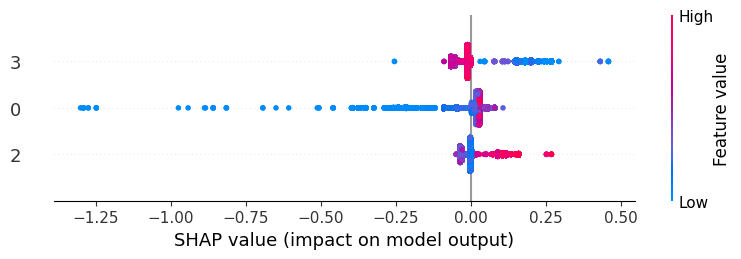

In [46]:
shap.summary_plot(shap_values.values, features=X_test_transformed_df, feature_names=selected_cols.tolist())


Antes de tudo, perceba que o melhor modelo resultou em uma seleção de apenas 3 dos 9 atributos do conjunto de dados original

---

O gráfico acima é um **SHAP summary plot**, uma forma de visualizar a importância e o efeito das variáveis em um modelo preditivo.  
Cada ponto representa uma observação (amostra do conjunto de dados), e sua posição no eixo horizontal indica o **impacto da feature no output do modelo** — isto é, o quanto aquela variável contribuiu para aumentar ou diminuir a predição.

- **Eixo X:** valor do SHAP (*SHAP value*), que quantifica o efeito local da variável sobre a saída do modelo.  
  - Valores **positivos** → contribuem para **aumentar** a predição.  
  - Valores **negativos** → contribuem para **diminuir** a predição.  
- **Eixo Y:** cada linha corresponde a uma **feature** (aqui, representadas por índices numéricos: 0, 2 e 3).  
- **Cores:** indicam o valor original da feature na amostra.  
  - Azul → valores **baixos**.  
  - Rosa → valores **altos**.  

`Interpretação dos resultados`

- As **features 0 e 3** - que correspondem respectivamente a *Dipole*, *E_HOMO*, *E_LUMO* -  apresentam a maior densidade de pontos próximos de zero, indicando **baixo impacto global** sobre o resultado do modelo.  
- Há poucos pontos com valores SHAP significativamente negativos (até -1.25), mostrando que apenas algumas amostras específicas têm efeito expressivo na redução da saída.  
- As **cores azul predominantes** sugerem que, em geral, **valores baixos das features** estão associados a impactos negativos no output do modelo.  
- Já os pontos em rosa (valores altos das features) concentram-se próximos de zero ou ligeiramente positivos, implicando que **valores altos têm efeito neutro ou levemente positivo** na predição.  

### 2.4 Bar plot

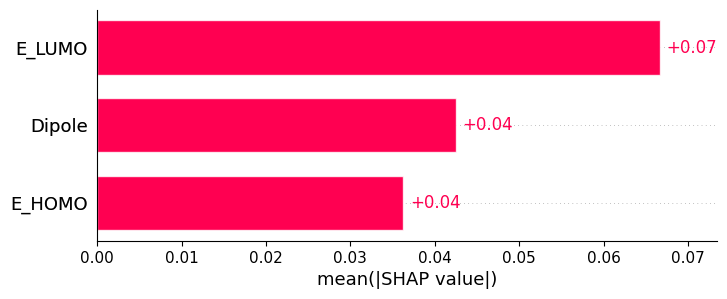

In [43]:
# shap_values já é um numpy.ndarray
shap_values_exp = shap.Explanation(
    values=shap_values,        # passa o array direto
    data=X_test,               # seu DataFrame de teste
    feature_names=X_test.columns
)

shap.plots.bar(shap_values_exp)

``Interpretação do *SHAP Bar Plot*``

O gráfico acima é um **bar plot de valores SHAP médios absolutos**, utilizado para quantificar a **importância global** de cada variável no modelo.  
Enquanto o *summary plot* mostra o impacto ponto a ponto (local), este gráfico resume o **efeito médio absoluto** das features sobre a saída, permitindo identificar **quais variáveis o modelo mais utiliza para tomar decisões**.

- **Eixo X:** valor médio absoluto de SHAP (*mean |SHAP value|*), que mede a **contribuição média** da feature no resultado do modelo.  
- **Eixo Y:** nomes das features avaliadas (`E_LUMO`, `Dipole`, `E_HOMO`).  
- **Anotação em rosa:** valor médio de impacto sobre a predição.

`Interpretação dos resultados`

- **`E_LUMO`** é a variável **mais influente**, com média de impacto de aproximadamente **0.07**.  
- **`Dipole`** e **`E_HOMO`** possuem importância semelhante (cerca de **0.04**), sugerindo que o modelo as utiliza de forma equilibrada, mas com menor peso que `E_LUMO`.  
- Essa diferença evidencia que o modelo depende majoritariamente da energia do **LUMO (Lowest Unoccupied Molecular Orbital)**, o que é fisicamente coerente em muitos contextos químicos, já que esse parâmetro está fortemente relacionado à reatividade e propriedades eletrônicas de moléculas.

### 2.5 Waterfall plot

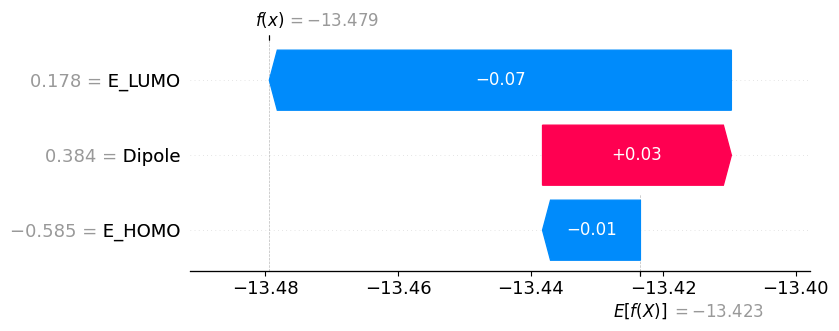

In [44]:
shap.plots.waterfall(shap_values_exp[1])


O gráfico acima é um **SHAP waterfall plot**, que mostra de forma detalhada **como cada feature contribuiu para a predição individual** de uma amostra específica.  
Ele decompõe o valor final da predição (`f(x)`) a partir do valor médio esperado do modelo (*expected value*, indicado como \( E[f(X)] \)), somando os efeitos de cada variável (valores SHAP).

- **Eixo X:** representa o valor predito pelo modelo, variando do valor médio \( E[f(X)] \) até o valor final \( f(x) \).  
- **Barras coloridas:** mostram o impacto de cada feature:
  - **Azul:** contribuição **negativa** (reduz a predição em relação à média).
  - **Rosa:** contribuição **positiva** (aumenta a predição em relação à média).  
- **Valores à esquerda:** indicam o valor original de cada variável para essa observação.

`Interpretação dos resultados`

- O valor médio esperado do modelo é **≈ –13.423**, e a predição final para esta amostra é **≈ –13.479**, indicando uma **leve redução** em relação à média.  
- A feature **`E_LUMO` (0.178)** possui o **maior impacto negativo** (≈ –0.07), sendo o principal fator responsável por essa diminuição.  
- A feature **`Dipole` (0.384)** contribui positivamente (+0.03), atenuando parcialmente o efeito negativo de `E_LUMO`.  
- Já **`E_HOMO` (–0.585)** tem um efeito negativo menor (–0.01), reforçando levemente a tendência de redução na predição.

## 3. Conclusão

Neste notebook conseguimos explorar o conceito de **interpretabilidade** em modelo de Machine Learning.

Utilizando o módulo *SHAP*, analisamos o melhor modelo do algoritmo *NGBoost* obtido pelo estudo via *optuna*, explorando aspectos quantitativos e qualitativos, compreeendendo melhor como os atributos selecionados contruiram indidual e coletivamente para as previsões.

Compreender como modelos de ML realizam suas previsões está se tornado cada vez mais almejado, principalmente em contextos onde a simples predição não é suficiente - como em diagnósticos clínicos, nos quais é importante entender como se chegou a determinada conclusão.

## Referências

LIGEIRO, Gabriel. Como interpretar seu modelo de machine learning usando SHAP values. Medium, 5 dez. 2020. Disponível em: https://gabrielligeiro.medium.com/como-interpretar-seu-modelo-de-machine-learning-usando-shap-values-2c61c0d26317
. Acesso em: 24 out. 2025.

LUNDBERG, Scott; LEE, Su-In. SHAP – Welcome to the SHAP documentation. 2018 (?). Disponível em: https://shap.readthedocs.io/en/latest/
. Acesso em: 24 out. 2025.

AWAN, Abid Ali. Uma introdução aos valores SHAP e à interpretabilidade do aprendizado de máquina. DataCamp, 11 set. 2024. Disponível em: https://www.datacamp.com/pt/tutorial/introduction-to-shap-values-machine-learning-interpretability
. Acesso em: 24 out. 2025.